## Topic_4B_Acegen · Target-conditioned de-novo drug design

**Note**: This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.


Authors:
- **Loulwah Arnaout, CADD Seminar, 2024, Saarland University**
- **Mohamed Moustafa Mohamadein Moustafa Salah, CADD Seminar, 2024, Saarland University**

## Aim of this talktorial

In this tutorial we will learn:
1. **How to condition de-novo drug design** towards the generation of novel drug candidates for a specifc target.
2. **How to leverage [ACEGEN](https://github.com/Acellera/acegen-open)**, a reinforcement-learning-based framework to generate molecules tailored to specific targets and constraints.
3. **How to use [MolScore](https://github.com/MorganCThomas/MolScore)** to construct custom scoring functions that utilize structural attributes to guide the reinforcement learning process. These attributes include:
   1. SMINA docking score of the generated molecule to our specific GPCR target.
   2. Predicted binding affinity of the generated molecule, obtained from a classification model trained on data for our specific GPCR target.

### Contents in *Theory*
- [De-novo drug design](#De-novo-drug-design)
  - [Ligand-based vs structure-based methods](#Ligand-based-vs-structure-based-methods)
  - [Conditioning generation to a target](#Conditioning-generation-to-target)
- [ACEGEN workflow](#ACEGEN-workflow)
- [Biological background](#Biological-background)
  - [Dopamine Receptro D2](#Dopamine-receptor-D2)
  - [Risperidone as reference ligand](#Risperidone-as-a-reference-legend)

### Contents in *Practical*
- [Environment setup](#Environment-setup)
- [Scoring functions setup](#Scoring-functions-setup)
  - [Model-based generation](#Model-based-generation)
  - [Docking-based generation](#Docking-based-generation)
- [Config files setup](#Config-files-setup)
- [Running Acegen](#Running-Acegen)
- [Results](#Results)

### References

* Theoretical background:

    - Sheng Wang et al., "Structure of the D2 dopamine receptor bound to the atypical antipsychotic drug risperidone" [Nature, 2018](https://doi.org/10.1038/nature25758).
    - Morgan Thomas et al., "Integrating structure-based approaches in generative molecular design" [Current Opinion in Structural Biology, 2023](https://doi.org/10.1016/j.sbi.2023.102559).
    - Tiago Sousa et al., "Generative Deep Learning for Targeted Compound Design" [Journal of Chemical Information and Modeling, 2021](https://doi.org/10.1021/acs.jcim.0c01496).

* Packages:
    * ACEGEN
        - GitHub: [acegen-open](https://github.com/Acellera/acegen-open)
        - Paper: Albert Bou et al., "ACEGEN: Reinforcement Learning of Generative Chemical Agents for Drug Discovery" [Journal of Chemical Information and Modeling, 2024](https://doi.org/10.1021/acs.jcim.4c00895).
    * MolScore
        - GitHub: [MolScore](https://github.com/MorganCThomas/MolScore)
        - Paper: Morgan Thomas et al., "MolScore: a scoring, evaluation and benchmarking framework for generative models in de novo drug design" [Journal of Cheminformatics, 2024](https://doi.org/10.1186/s13321-024-00861-w).
    * PDBFixer [manual](https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html)
    * [ProDy](http://www.bahargroup.org/prody/)
    * [SwissTargetPrediction](http://www.swisstargetprediction.ch/)


* Dataset:
    - D2 Receptor Binding Affinity: This dataset contains information on the binding affinity (pCHEMBL values) of various chemical compounds against the D2 dopamine receptor.

## Theory

### De-novo drug design

De-novo drug design is the generation of novel molecules from scratch using computational methods.

#### Ligand-based vs structure-based methods
Among the computational methods used in de-novo drug design are generative models, which train known architectures such as Recurrent Neural Networks (RNNs) or Autoencoders on existing data to guide the generation towards a target of choice.

For more details about Neural Networks and how they function, please refer to [Talktorial T022](https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html).

The type of data used to train these models can be:

- **Ligand-based**: learning from known ligands of the target the properties of a potential drug.
- **Structure-based**: learning from the structure of the target itself the properties of a potential drug.


As opposed to ligand-based techniques that require a data-rich target, and are likely to produce drugs that resemble already known ligands, structure-based techniques focus on generating molecules that satisfy specific interactions with residues in the binding pocket, while also exploring novel chemical space.

#### Conditioning generation to target
To incorporate this structural information into the generation process, we can do so:

* **Explicitly** through Distribution Learning, by learning from the structure of the protein/ligand complex, the conditional distribution of small molecules.
* **Implicitly** by incorporating scores that provide information related to the target and its structure, such as docking scores or predicted binding affinities, but not the structure itself.

In this talktorial, we will be focusing on the latter and using model-based and docking-based custome scoring functions to guide the generation.

### ACEGEN workflow

**ACEGEN** is a **[TorchRL](https://pytorch.org/rl/stable/index.html)**-based toolkit that can execute this task seamlessly. Among its many functionalities, it allows us to use the structure-implicit scores as reward values for **Reinforcement Learning (RL)**, to update the model's parameters and optimize the scores of future proposed molecules.

The molecules can be scored easily using **Molscore**, a scoring function suite already incorporated into ACEGEN to evaluate the generated molecules by various measures, such as docking scores, predicted activity, synthesizability, and diversity. The scores can then be used along with one of the RL algorithms provided in ACEGEN, such as Reinvent, Augmented Hill-Climb (AHC), or Advantage Actor-Critic (A2C), to bias the generation process to desired properties.

<img alt="ACEGEN workflow" src="./src/images/ACEGEN_workflow.png" width="600" height="550"/>

*Figure 1:* 
General overview of any of the ACEGEN implementations. Different ACEGEN implementations vary in the algorithm used, and allow to customize the generative models and the scoring functions.
Figure and description taken from: [Journal of Chemical Information and Modeling, 2024](https://doi.org/10.1021/acs.jcim.4c00895).

### Biological background

#### Dopamine receptor D2
In this talktorial, we will be generating molecules specific to the Dopamine Receptor D2 ([DRD2](https://www.rcsb.org/structure/6cm4)), a target for antipsychotic drugs as well as Parkinson's disease drugs.

As its name suggests, this receptor binds the neurotransmitter Dopamine, which is involved in processes such as control of coordinated movement, metabolism and hormonal secretion.

#### Risperidone as a reference legend
The PDB entry used also includes the compound Risperidone in complex with our target. Risperidone is a widely prescribed antipsychotic drug. We will be using it as a pointer to the binding pocket to which we would like the generated molecules to be specific.

## Practical
The practical part of this talktorial covers the setting up of the conda environment with the necessary packages to run ACEGEN, as well as the setting up of two scoring functions: a classification-model-based scoring function, and a docking-based scoring function.

We will learn how to prepare the configuration files to be used to run ACEGEN with MolScore for molecule generation.

### Environment setup
1. **Install Conda**: make sure that you have conda installed on your system, if not please visit [Miniconda](https://docs.anaconda.com/miniconda/install/) and follow the installation instructions based on your system.
2. **Create the Environment**: Run the following command in your terminal to create `acegen` environment with `python=3.10` and jupyter:
   ```bash
   conda create -n acegen python=3.10 jupyter
   ```
3. **Activate the Environment**: Once created, activate the environment:
    ```bash
    conda activate acegen
    ```
4. **Run jupyter lab using the following command**: make sure that you have GIT installed on your system, then run the following command in your terminal:
    ```bash
    jupyter-lab /path/to/notebook/directory
    ```
5. **Run the following cells to install the necessary packages**

In [1]:
# installation of torch
# > /dev/null 2>&1
!conda install pytorch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 pytorch-cuda=12.1 -c pytorch -c nvidia -y

Channels:
 - pytorch
 - nvidia
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: / 

## Package Plan ##

  environment location: /home/mohamed/miniconda3/envs/acegen

  added / updated specs:
    - pytorch-cuda=12.1
    - pytorch==2.4.1
    - torchaudio==2.4.1
    - torchvision==0.19.1


The following NEW packages will be INSTALLED:

  aom                conda-forge/linux-64::aom-3.6.1-h59595ed_0 
  blas               conda-forge/linux-64::blas-1.0-mkl 
  cpython            conda-forge/noarch::cpython-3.10.16-py310hd8ed1ab_1 
  cuda-cudart        nvidia/linux-64::cuda-cudart-12.1.105-0 
  cuda-cupti         nvidia/linux-64::cuda-cupti-12.1.105-0 
  cuda-libraries     nvidia/linux-64::cuda-libraries-12.1.0-0 
  cuda-nvrtc         nvidia/linux-64::cuda-nvrtc-12.1.105-0 
  cuda-nvtx          nvidia/linux-64::cuda-nvtx-12.1.105-0 
  cuda-opencl        nvidia/linux-64::cuda-opencl-12.6.77-0 
  cuda-runtime       nv

In [2]:
# install torchrl & tensordict and additional acegen dependencies
!conda install conda-forge::pytorchrl=0.5.0 conda-forge::tensordict=0.5.0 conda-forge::flake8 conda-forge::pytest conda-forge::pytest-cov conda-forge::hydra-core conda-forge::tqdm conda-forge::wandb conda-forge::rdkit conda-forge::prody conda-forge::pdbfixer -y

Channels:
 - conda-forge
 - bioconda
 - defaults
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 

## Package Plan ##

  environment location: /home/mohamed/miniconda3/envs/acegen

  added / updated specs:
    - conda-forge::flake8
    - conda-forge::hydra-core
    - conda-forge::pdbfixer
    - conda-forge::prody
    - conda-forge::pytest
    - conda-forge::pytest-cov
    - conda-forge::pytorchrl=0.5.0
    - conda-forge::rdkit
    - conda-forge::tensordict=0.5.0
    - conda-forge::tqdm
    - conda-forge::wandb


The following NEW packages will be INSTALLED:

  annotated-types    conda-forge/noarch::annotated-types-0.7.0-pyhd8ed1ab_1 
  antlr-python-runt~ conda-forge/noarch::antlr-python-runtime-4.9.3-pyhd8ed1ab_1 
  appdirs            conda-forge/noarch::appdirs-1.4.4-pyhd8ed1ab_1 
  biopython          conda-forge/linux-64::biopython-1.85-py310ha75aee5_1 
  brotli             conda-forge/linux-64::brotli-1.1.0-hb9d3cd8_2 
 

In [3]:
# installing acegen (make sure that you have git installed on your system)
!pip install git+https://github.com/Acellera/acegen-open.git 

  Cloning https://github.com/Acellera/acegen-open.git to /tmp/pip-req-build-f6qlq4l8
  Running command git clone --filter=blob:none --quiet https://github.com/Acellera/acegen-open.git /tmp/pip-req-build-f6qlq4l8
  Resolved https://github.com/Acellera/acegen-open.git to commit 6102f3902686755187d19618e1033ab39cb712b9
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for acegen: filename=acegen-1.0-py3-none-any.whl size=104776498 sha256=4b03dc7e6c5ccd537de4a302f1350ca4b548919518315959b6c4d30c154c608b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0s9e7nrr/wheels/24/0e/0b/01e8a42894c80b8dc21f4e4db4ce276d11fd9b58778c480b01
Successfully built acegen


In [4]:
# installind molscore's dependencies
!conda install conda-forge::python-levenshtein sfe1ed40::streamlit-plotly-events conda-forge::streamlit conda-forge::molbloom conda-forge::func_timeout conda-forge::flask openeye::openeye-toolkits conda-forge::prolif bioconda::smina conda-forge::openbabel conda-forge::dask conda-forge::scikit-learn bioconda::reduce conda-forge::mdanalysis=2.7.0 -y

Channels:
 - conda-forge
 - bioconda
 - defaults
 - openeye
 - sfe1ed40
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 

## Package Plan ##

  environment location: /home/mohamed/miniconda3/envs/acegen

  added / updated specs:
    - bioconda::reduce
    - bioconda::smina
    - conda-forge::dask
    - conda-forge::flask
    - conda-forge::func_timeout
    - conda-forge::mdanalysis=2.7.0
    - conda-forge::molbloom
    - conda-forge::openbabel
    - conda-forge::prolif
    - conda-forge::python-levenshtein
    - conda-forge::scikit-learn
    - conda-forge::streamlit
    - openeye::openeye-toolkits
    - sfe1ed40::streamlit-plotly-events


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-sdk-cpp-1.11.489       |       h4d475cb_0         3.0 MB  conda-forge
    libarrow-19.0.0            |   h00a82cf_6_cpu         8.6 MB  co

In [5]:
# installing molscore
!pip install molscore zenodo-client

  Using cached zenodo_client-0.3.6-py3-none-any.whl.metadata (10 kB)
  Using cached pystow-0.7.0-py3-none-any.whl.metadata (17 kB)
  Using cached more_click-0.1.2-py3-none-any.whl.metadata (4.3 kB)
Using cached zenodo_client-0.3.6-py3-none-any.whl (14 kB)
Using cached pystow-0.7.0-py3-none-any.whl (38 kB)
Using cached more_click-0.1.2-py3-none-any.whl (6.7 kB)


In [6]:
# importing the required packages and modules
from pathlib import Path
import math
from pickle import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from prody import fetchPDB, parsePDB, writePDB
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, rdFingerprintGenerator, DataStructs
from molscore.scoring_functions.sklearn_model import SKLearnClassifier

In [7]:
# setting up the necessary files' paths
HERE = Path.cwd() / "src"
configs_path = HERE / "configs"
scripts_path = HERE / "scripts"
data_path = HERE / "data"
results_path = HERE / "results"

### Scoring functions setup

#### Model-based generation
In the model-based generation we want to guide the  model towards the generation of active molecules targeting our Dopamine Receptor D2.

To predict this activity for newly generated molecules, we utilize a dataset of compounds with known DRD2 binding affinities, measured as *pchembl_value_Mean*, to train a Random Forest Classification model (RFC), using Scikit-learn. The ECFP4 fingerprints of the molecules are used as features to classify them as either active or inactive, depending on whether their *pchembl_value_Mean* passes a predefined threshold.

This classification will guide the generation process.

We begin with preparing the dataset by labelling the molecules with their output (active or inactive) and generating their molecular fingerprints to be used as input features.

In [8]:
# First, we need to define a function to generate molecular fingerprints.
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
def get_fingerprint(smiles):
    """
    Generates an ECFP4 fingerprint for a given molecule SMILES string.

    Parameters
    ----------
    smiles : str
        A SMILES string representing the molecule.

    Returns
    -------
    binary_array: np.ndarray or None
        A NumPy array representing the ECFP4 fingerprint with a size of 1024 if the 
        molecule is valid and the fingerprint could be generated. Returns None if the 
        provided SMILES string cannot be converted into a valid RDKit molecule.
    """
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        fingerprint = generator.GetFingerprint(molecule)
        binary_array = np.zeros((1024,), dtype=int)
        DataStructs.ConvertToNumpyArray(fingerprint, binary_array)
        return binary_array
    else:
        return None

# Next, we'll prepare the data and label active/inactive molecules.
data = pd.read_csv(data_path/"D2_receptor_P14416WT_Papyrus_High.csv")
activity_threshold = 7
data['activity'] = data['pchembl_value_Mean'].apply(lambda x: 1 if x >= activity_threshold else 0)

# Now, we'll generate the ECFP4 feature vectors for our molecules.
fingerprints = pd.DataFrame({smile: get_fingerprint(smile) for smile in data["SMILES"]}).T.reset_index().drop("index", axis=1)
df = pd.concat([data, fingerprints], axis=1)

# Let's take a look at the processed dataframe.
df.head()

,Activity_ID,SMILES,target_id,pchembl_value_Mean,activity,0,1,2,3,4,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,AADCDMQTJNYOSS_on_P14416_WT,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,P14416_WT,9.863333,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,AADWBQLQKGQDIM_on_P14416_WT,O=C(CCCN1CCC(c2cc3ccc2CCc2ccc(cc2)CC3)CC1)c1cc...,P14416_WT,7.645000,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,AAELEHAFAYIZRH_on_P14416_WT,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,P14416_WT,8.370000,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AAIDTVFHOXBFSJ_on_P14416_WT,CC(C)CN1CCOC2c3cc4c(cc3CCC21)CCO4,P14416_WT,5.300000,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,AAONJNLMLWRZJE_on_P14416_WT,Cc1ccc2c(-c3nnc(SCCCN4CC5CC5(c5ccc(Cl)cc5)C4)n...,P14416_WT,6.400000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Then we split the data into training and test sets and train the model.

In [9]:
# For model training, we need to split the data appropriately.
X = df.drop(['Activity_ID', 'SMILES', 'target_id', 'pchembl_value_Mean', 'activity'], axis=1)
y = df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using the best parameters found earlier, let's train our classification model.
model = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300
)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42)

We evaluate the performance of the model on the test data.

In [10]:
# We want to evaluate the performance of our trained model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8623188405797102
Precision: 0.8647887323943662
Recall: 0.7831632653061225
F1-score: 0.821954484605087
AUC: 0.8497697859631659
Confusion Matrix:
 [[526  48]
 [ 85 307]]


Finally, we'll save our trained model for future use with ACEGEN and MolScore.

In [11]:
# Finally, we'll save our trained model for future use with ACEGEN and MolScore.
with open(data_path/"model.pkl", 'wb') as file:
    dump(model, file)

#### Docking-based generation

In docking-based generation, we want to guide the model towards generating molecules with improved docking score to our target.

As the molecules are generated, we dock them to the target using MolScore's implimentation of SMINA, testing multiple poses and keeping the best one along with its score to be used as a reward value for reinforcement learning.

Please refer to [Talktorial T015](https://projects.volkamerlab.org/teachopencadd/talktorials/T015_protein_ligand_docking.html) for more details about protein-ligand docking.

**Preparing protein and ligand files**

First, we need to prepare the input data necessary for this technique, and consisting of the structure of the target protein and a chosen reference ligand. This is done with the help of ProDy to parse and manipulate the PDB file.

The structure of the protein will be used for docking, and that of the ligand in its 3D-bioactive conformation will allow us to determine the coordinates of the binding pocket into which we will dock the generated molecules later on.

In [12]:
# retrieve structure of the protein/ligand complex from the PDB
pdb_id = "6cm4"
pdb_file = fetchPDB(pdb_id, folder=str(data_path))

# parse PDB structure to be able to manipulate its contents
structure = parsePDB(pdb_file)

# select protein and save in a separate file
protein = structure.select("protein")
writePDB(str(data_path / "protein.pdb"), protein)

# select ligand and save in a separate file
ligand_resname = "8NU"
ligand = structure.select(f"resname {ligand_resname}")
writePDB(str(data_path / "ligand.pdb"), ligand)

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 6cm4 downloaded (src/data/6cm4.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 3236 atoms and 1 coordinate set(s) were parsed in 0.03s.


'/home/mohamed/Documents/src/data/ligand.pdb'

The protein structure is then prepared for docking by adding missing residues and atoms.

In [13]:
# read structure file
fixer = PDBFixer(filename=str(data_path/"protein.pdb"))

# add missing information
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens()

# write prepared structure to a new pdb file
PDBFile.writeFile(fixer.topology, fixer.positions, open(data_path/'prepared_protein.pdb', 'w'))

### Config files setup

To set up the configuration files for Molscore, a GUI can be used by running the command `molscore_config`. This will launch a graphical interface where it is possible to configure the Molscore settings for both model and docking-based scoring functions. Once the desired configuration is set up, be sure to save the configuration file in the appropriate directory. In this example, we have provided the Molscore config files for both scoring functions.

Additionally, the second configuration file provided is for ACEGEN. It can be accessed, viewed, and modified to adjust the reinforcement learning model parameters or the number of smiles to generate through the model. To do this, simply open the Acegen configuration file and make any necessary changes to tailor the reinforcement learning model to your specific needs.

### Running Acegen

1. **Model Based Generation**

In [14]:
# Now that we have our classification model, we can use it to guide molecule generation.
!python {scripts_path/"reinvent.py"} --config-path {configs_path} --config-name RFC_config_denovo.yaml

/home/mohamed/miniconda3/envs/acegen/lib/python3.10/site-packages/prolif/datafiles.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
100100it [08:17, 201.34it/s]                                                    


2. **Docking Based Generation**

Here, 50 molecules were generated in 25 steps (2 in each) due to limited computational resources. While this number is insufficient for reinforcement learning to show its full potential, it allows us to demonstrate the application of docking-based scoring in ACEGEN.

In [15]:
# now we can use the docking score based scoring function to guide the molecule generation
!python {scripts_path/"reinvent.py"} --config-path {configs_path} --config-name SMINA_config_denovo.yaml

/home/mohamed/miniconda3/envs/acegen/lib/python3.10/site-packages/prolif/datafiles.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
1 molecule converted
[2025-01-23 18:42:11,406][smina][DEBUG] - Written 1_0-0  | 0/50 [00:00<?, ?it/s]
[2025-01-23 18:42:11,406][smina][DEBUG] - Written 1_0-1
[2025-01-23 18:42:11,406][smina][DEBUG] - Written 1_0-2
[2025-01-23 18:42:11,407][smina][DEBUG] - Written 1_0-3
[2025-01-23 18:42:11,407][smina][DEBUG] - Written 1_0-4
[2025-01-23 18:42:11,407][smina][DEBUG] - Written 1_0-5
[2025-01-23 18:42:11,408][smina][DEBUG] - Written 1_1-0
[2025-01-23 18:42:11,408][smina][DEBUG] - Written 1_1-1
[2025-01-23 18:42:11,408][smina][DEBUG] - Written 1_1-2
[2025-01-23 18:42:11,408][smina][DEBUG] - Written 1_1-3
[2025-01-23 18:42:11,409][smina][DEBUG] - Written 1_1-4
[2025-01-23 18:42:11,409][smina][DEBUG] - Written 1_1-5
[2025-01-23 18:42:11,409][sm

### Results

1. **Model Based Generation**

We inspect the scores of the generated molecules and check the highest ones reached.

In [25]:
rfc_df = pd.read_csv("results/RFC_reinvent_2025_01_23_183310/2025_01_23_reinvent_RFC/scores.csv", index_col = 0)
print(f"MAX predicted probability: {rfc_df['RFC_pred_proba'].max()}")
print(f"MEDIAN predicted probability: {rfc_df['RFC_pred_proba'].median()}")
active_molecules_rfc = rfc_df[(rfc_df['RFC_pred_proba'] >= 0.5) & (rfc_df['unique'] == True)].sort_values('RFC_pred_proba', ascending=False).reset_index().drop("index", axis=1)
active_molecules_rfc.head()

MAX predicted probability: 0.9937104994781296
MEDIAN predicted probability: 0.9192938289516375


,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,RFC_pred_proba,raw_RFC_pred_proba,single,filter,score_time
0,reinvent,RFC,358,42,228.377146,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)NC1CC1,True,1,True,0,0.993710,0.993710,0.993710,1.0,0.091390
1,reinvent,RFC,434,45,275.691345,O=C(NC1CCC(CCN2CCCN(c3nsc4ccccc34)CC2)CC1)NC1CC1,True,1,True,0,0.993195,0.993195,0.993195,1.0,0.100047
2,reinvent,RFC,750,43,474.306006,S=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)NC1CC1,True,1,True,0,0.992599,0.992599,0.992599,1.0,0.091191
3,reinvent,RFC,425,60,270.157204,CC1(C)CC1NC(=O)NC1CCC(CCN2CCN(c3nsc4ccccc34)CC...,True,1,True,0,0.992282,0.992282,0.992282,1.0,0.089838
4,reinvent,RFC,631,64,399.822570,CC1(O)CC1NC(=O)NC1CCC(CCN2CCN(c3nsc4ccccc34)CC...,True,1,True,0,0.992282,0.992282,0.992282,1.0,0.088448


We then visualize the improving score of the generated molecules as reinforcement learning is applied. Here, it is viewed as an average score given that multiple molecules are generated simultaneously in each training step of the generative model.

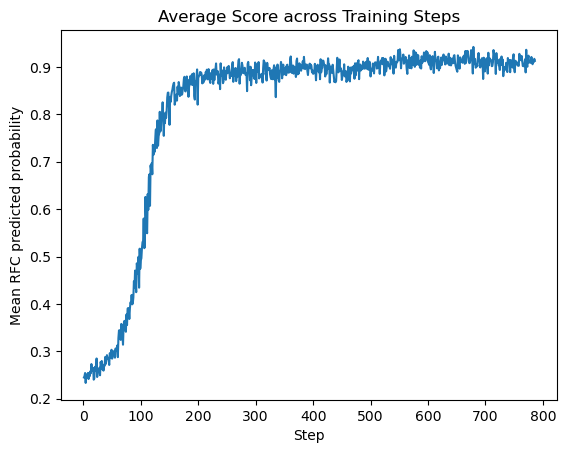

In [46]:
# viewinig the scoring function performance of the generated molecules
grouped_data = rfc_df.groupby(['step'])['RFC_pred_proba'].mean()
plt.plot(grouped_data.index, grouped_data.values)
plt.xlabel('Step')
plt.ylabel('Mean RFC predicted probability')
plt.title('Average Score across Training Steps')
plt.show()

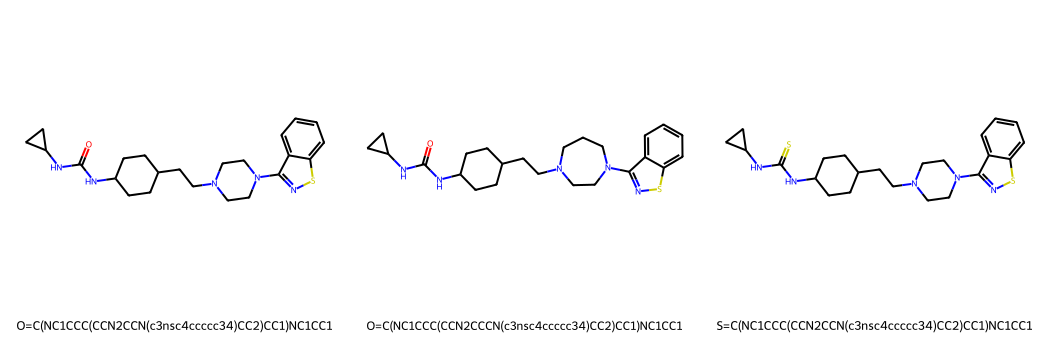

In [19]:
# Drawing the active molecules using rdkit
active_molecules_rfc['molecules'] = active_molecules_rfc['smiles'].apply(Chem.MolFromSmiles)
molecules = active_molecules_rfc['molecules'].tolist()[:3]
molecules_image = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    subImgSize=(350, 350),
    legends=active_molecules_rfc['smiles'].tolist()[:3]
)
molecules_image

We selected an active molecule `O=C(NC1CCC(CCN2CCCN(c3nsc4ccccc34)CC2)CC1)NC1CC1` from those generated by Acegen and performed target prediction using [SwissTargetPrediction](http://www.swisstargetprediction.ch/). The results indicated that the molecule is most likely associated with the Dopamine D2 receptor, aligning with the target we originally used to train the model.

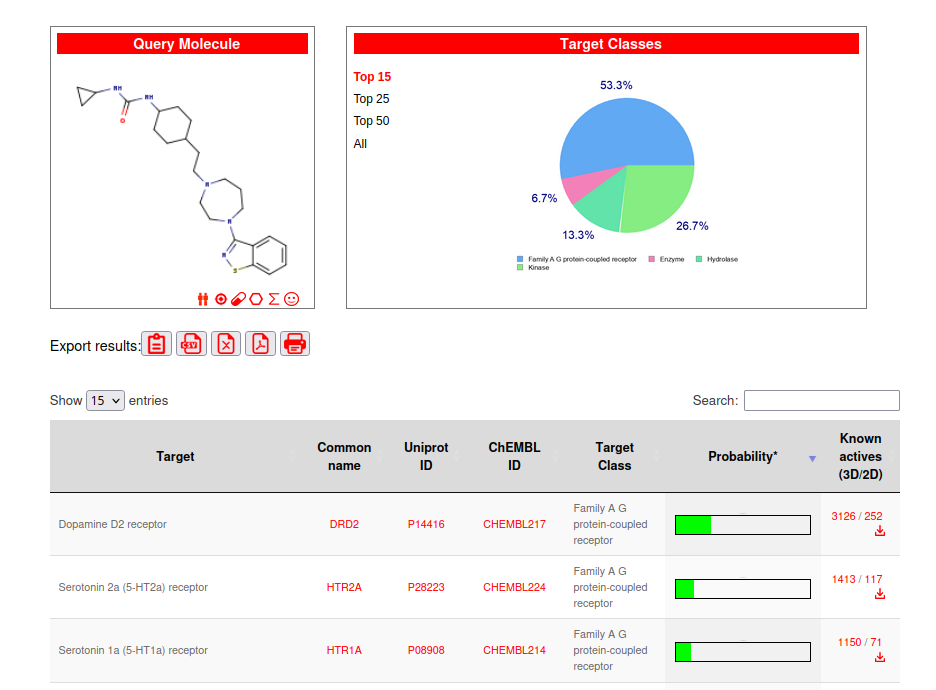

*Figure 2:* 
Target prediction of an active molecule using [SwissTargetPrediction](http://www.swisstargetprediction.ch/).

2. **Docking Based Generation**

We inspect the scores of the generated molecules and check the highest ones reached. Here we note that a low docking score is an indicator of good binding.

In [28]:
smina_df = pd.read_csv("results/SMINA_reinvent_2025_01_23_184154/2025_01_23_reinvent_SMINA/scores.csv", index_col = 0)
print(f"MAX predicted docking score: {smina_df['smina_docking_score'].min()}")
print(f"MEDIAN docking score: {smina_df['smina_docking_score'].median()}")
active_molecules_smina = smina_df[(smina_df['smina_docking_score'] <= -9) & (smina_df['unique'] == True)].sort_values('smina_docking_score', ascending=True).reset_index().drop("index", axis=1)
active_molecules_smina.head()

MAX predicted docking score: -12.1
MEDIAN docking score: -9.4


,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,smina_docking_score,smina_NetCharge,smina_PositiveCharge,smina_NegativeCharge,smina_best_variant,raw_smina_docking_score,single,filter,score_time
0,reinvent,SMINA,23,0,1581.889930,CNC(=O)c1ccc2c(c1)c1ccc(-c3nnc(-c4ccc(F)cc4)[n...,True,1,True,0,-12.1,0.0,0.0,0.0,23_0-1,0.000001,0.000001,1.0,34.373061
1,reinvent,SMINA,2,0,116.285158,N#Cc1cc(S(=O)(=O)Nc2nncs2)c(F)cc1Oc1ccc(S(N)(=...,True,1,True,0,-11.6,0.0,0.0,0.0,2_0-2,0.000001,0.000001,1.0,144.296567
2,reinvent,SMINA,16,1,998.105747,COc1cnc(N2CCC(c3n[nH]c4c3C(C(F)(F)F)CC(NC3CC(F...,True,1,True,0,-11.3,0.0,0.0,0.0,16_1-1,0.000001,0.000001,1.0,156.487077
3,reinvent,SMINA,1,1,16.070421,CCOC(=O)n1ccc2cnc(Nc3cccc(NC(=O)c4cccc(S(C)(=O...,True,1,True,0,-11.1,0.0,0.0,0.0,1_1-1,0.000001,0.000001,1.0,99.897627
4,reinvent,SMINA,4,0,266.699041,CC1CN(c2ccn3c(C#N)c(-c4ccc(F)cc4)nc3c2)CCN1c1c...,True,1,True,0,-11.1,-1.0,0.0,-1.0,4_0-1,0.000001,0.000001,1.0,66.892138


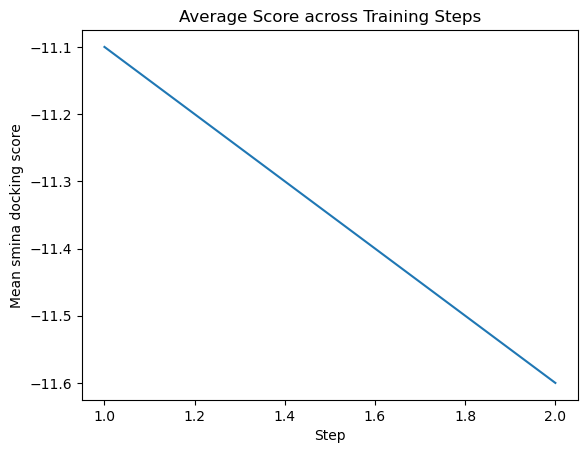

In [44]:
# viewing the scoring function performance of the generated molecules
grouped_data = smina_df.groupby(['step'])['smina_docking_score'].min()[:2]
plt.plot(grouped_data.index, grouped_data.values)
plt.xlabel('Step')
plt.ylabel('Mean smina docking score')
plt.title('Average Score across Training Steps')
plt.show()

Here, 50 molecules were generated in 25 steps (2 in each) due to limited computational resources. While this number is insufficient for reinforcement learning to show its full potential, it allows us to demonstrate the application of docking-based scoring in ACEGEN. Generating more molecules is possible by navigating to the ACEGEN config file and modifying the total_smiles parameter

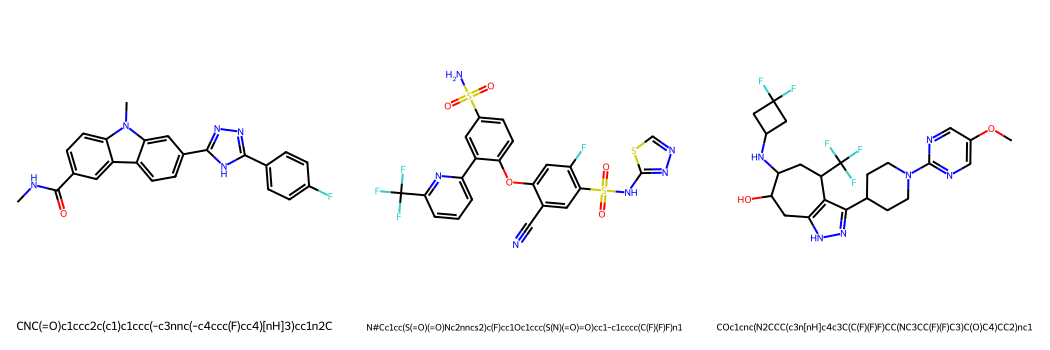

In [33]:
# Drawing the active molecules using rdkit
active_molecules_smina['molecules'] = active_molecules_smina['smiles'].apply(Chem.MolFromSmiles)
molecules = active_molecules_smina['molecules'].tolist()[:3]
molecules_image = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    subImgSize=(350, 350),
    legends=active_molecules_smina['smiles'].tolist()[:3]
)
molecules_image

### Discussion

In this talktorial, we used ACEGEN to condition the generation of de-novo candidate drugs towards our target DRD2, by optimizing two predictors of the molecules: activity and docking score. The activity was predicted by a classifier model trained on known ligands of DRD2, and the docking score was obtained by running SMINA with the structure of this target.

The model-based scoring is far more computationally efficient than the docking-based scoring. Due to that fact, we were able to generate a significant number of molecules using model-based scoring, allowing the generative model to learn the desired features by reinforcement learning, and thus observing improvement of scores over time. We were also able to further validate this method by observing the agreement between the high predicted activity of a generated molecule against DRD2 and the identification of DRD2 as its top predicted target.

### Quiz

- What is an advantage of using structure-based drug design methods?
- How is a structure-implicit score incorporated in the generation process?
- Many parameters of the Reinforcement learning model have not been touched upon here. Experiment by modifying these parameters in the ACEGEN config file. How does that affect the convergence of the generated molecules?